# MLOps Exercise: Medical Image Classification with Chest X-Ray Images

## Introduction

In this exercise, you'll gain practical experience with MLOps (Machine Learning Operations) by working on a real-world problem: classifying chest X-ray images to diagnose pneumonia. You'll go through various stages, from data cleaning to deployment, learning how to manage an end-to-end machine learning pipeline.

### Prerequisites

- Basic understanding of Python
- Familiarity with machine learning concepts
- Experience with Jupyter Notebooks

### Tools and Libraries

- Python
- NumPy
- OpenCV
- TensorFlow/Keras
- scikit-learn
- Flask
- Matplotlib
- imbalanced-learn

These libraries should cover most requirements for this exercise, including data manipulation (NumPy, pandas), visualization (Matplotlib), machine learning (scikit-learn, TensorFlow), image processing (OpenCV), and class imbalance treatment (imbalanced-learn).

### Table of Contents

1. [Data Loading and Cleaning](#Data-Loading-and-Cleaning)
2. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
3. [Class Imbalance](#Class-Imbalance)
4. [Model Building](#Model-Building)
5. [Data Augmentation](#Data-Augmentation)
6. [Model Evaluation](#Model-Evaluation)
7. [Model Deployment (Bonus)](#Model-Deployment-(Bonus))


## Environment Setup

Before we begin, let's set up the environment. We'll install the necessary Python packages for this exercise.

```bash
pip install numpy pandas opencv-python matplotlib scikit-learn tensorflow flask
```

You can also create a `requirements.txt` file with the above packages and install them using `pip install -r requirements.txt`.
Be aware that you should download ipykernel and export your env to the jupyter notebook.
```bash
python -m ipykernel install --user --name=my_new_env
```

In [ ]:
#! pip install numpy pandas opencv-python matplotlib scikit-learn tensorflow flask

## Data Loading and Cleaning

### Objective

Load the dataset and clean it by removing corrupted images.

### Guidance

1. Download the Chest X-Ray Images (Pneumonia) dataset and place it in a directory accessible by this notebook. From https://ametice.univ-amu.fr
2. Unzip the dataset and explore its directory structure.
3. Load the images and labels for training.
4. Write a function to scan for and remove any corrupted or invalid images.

### Exercise

Now, load the dataset use the zipfile library and clean it by removing corrupted images. Write your code in the cell below.

```python
import zipfile

zip_file_path = 'path/to/your/zip/file.zip'
extract_path = 'path/to/extract/folder'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
```

After extracting, your dataset should have the following folder structure:

```
/
|-- test/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- train/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- val/
    |-- NORMAL/
    |-- PNEUMONIA/
```

You can point `train_path` and `test_path` to the `train` and `test` folders inside this extracted directory

import zipfile

zip_file_path = 'C:/Users/Mouhcine FERDOUS/Desktop/etude/sid/MSD/Dataset.zip'
extract_path = 'C:/Users/Mouhcine FERDOUS/Desktop/etude/sid/MSD'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import tensorflow as tf
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from sklearn.preprocessing import LabelEncoder

In [5]:
import os
DIR = os.listdir('E:/Mes dossiers/M2 SID/DataScience/Datasets/chest_xray/train')
print(DIR)

['NORMAL', 'PNEUMONIA']


In [6]:
labels = ["NORMAL", "PNEUMONIA"]
IMG_SIZE = 256
def delCorrupted(folder_path):
    for iname in os.listdir(folder_path):
        img_path=os.path.join(folder_path,iname)
        try:
            Image.open(img_path)
            #print(str(iname))
        except :
            print("corrupted image found",str(iname))
            os.remove(img_path)
    
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        delCorrupted(path)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [7]:
train_folder = 'E:/Mes dossiers/M2 SID/DataScience/Datasets/chest_xray/train'
test_folder = 'E:/Mes dossiers/M2 SID/DataScience/Datasets/chest_xray/test'
val_folder = 'E:/Mes dossiers/M2 SID/DataScience/Datasets/chest_xray/val'

In [8]:
os.listdir(train_folder)

['NORMAL', 'PNEUMONIA']

In [9]:
train=get_data(train_folder)
test=get_data(test_folder)
val=get_data(val_folder)

In [10]:
print('the number of images extracted to train is :', train.size)
print('the number of images extracted to test is :', test.size)
print('the number of images extracted to validate is :', val.size)

the number of images extracted to train is : 10432
the number of images extracted to test is : 1248
the number of images extracted to validate is : 32


## Exploratory Data Analysis (EDA)

### Objective

Understand the dataset's basic statistics and visualize the data.

### Guidance

1. Use matplotlib to visualize some sample images from each class.
2. Investigate the distribution of classes (Pneumonia/Normal).

### Exercise

Perform exploratory data analysis on the dataset. Write your code in the cell below.


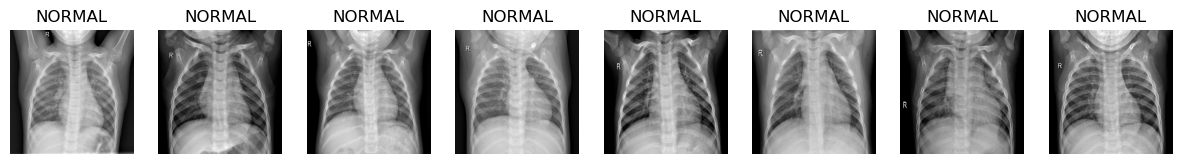

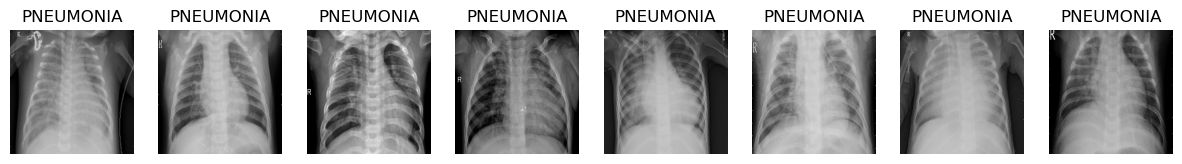

In [11]:
num_samples = 8  # Number of sample images to display per class

for label in labels:
    class_data = train[train[:, 1] == labels.index(label)]
    sample_images = class_data[:num_samples, 0]

    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(sample_images[i], cmap='gray')
        plt.title(label)
        plt.axis('off')

plt.show()

In [12]:
def ditribution(tab):
    l=[]
    for i in tab:
        if(i[1] == 0):
            l.append("PneumoniaNormal")
        else:
            l.append("Normal")

    sns.countplot(l)

## Class Imbalance

### Objective

Understand how class imbalance affects model performance and learn ways to mitigate it.

### Guidance

1. Train a baseline model without accounting for class imbalance.
2. Evaluate its performance using metrics like accuracy, precision, recall, and F1-score.
3. Experiment with techniques like class weighting or oversampling methods like SMOTE to balance the classes.

### Exercise

Address the class imbalance and evaluate the impact on the model. Write your code in the cell below.


In [13]:
images = train[:, 0]
class_labels = train[:, 1]
test_images=test[:, 0]
test_class_labels=test[:, 1]
val_images=val[:, 0]
val_class_labels=val[:, 1]
test_images_flat=np.array([img.flatten() for img in test_images])
val_images_flat=np.array([img.flatten() for img in val_images])
images_flat=np.array([img.flatten() for img in images])
test_class_labels=test_class_labels.astype(int)
val_class_labels=val_class_labels.astype(int)
class_labels=class_labels.astype(int)

In [14]:
def preprocess_data(data):
    X = []
    y = []
    for feature, label in data:
        X.append(feature)
        y.append(label)
    return np.array(X), np.array(y)

In [15]:
train_data = preprocess_data(train)
test_data = preprocess_data(test)
val_data = preprocess_data(val)

In [16]:
sm = SMOTE(sampling_strategy='not minority', random_state=42)
x_resampled, y_resampled = sm.fit_resample(images_flat, class_labels)
x_resampled=x_resampled.reshape(-1, IMG_SIZE, IMG_SIZE)

In [17]:
def training_data(x,y,val_d,model_path):
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x, y, epochs=2, batch_size=32, validation_data=(val_d[0], val_d[1]))
    model.save(model_path)

In [18]:
def testing_data(model, t_data):
    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(t_data[0], t_data[1])
    print(f'Test accuracy: {test_accuracy}')
    
    # Generate predictions
    predictions = (model.predict(t_data[0]) > 0.5).astype(int)
    
    # Calculate precision, recall, F1-score
    report = classification_report(t_data[1], predictions)
    print(report)
    
    return test_loss, test_accuracy

In [1]:
training_data(train_data[0],train_data[1],val_data,'model_imbalanced.h5')
training_data(x_resampled,y_resampled,val_data,'model_balanced.h5')

NameError: name 'training_data' is not defined

## Load the saved model
loaded_im_model = tf.keras.models.load_model('model_imbalanced.h5')

In [53]:
testing_data(loaded_im_model,test_data)

20/20 [==============================] - 8s 369ms/step - loss: 1.9314 - accuracy: 0.6907
Test accuracy: 0.6907051205635071
20/20 [==============================] - 8s 376ms/step
              precision    recall  f1-score   support

           0       0.96      0.18      0.31       234
           1       0.67      0.99      0.80       390

    accuracy                           0.69       624
   macro avg       0.81      0.59      0.55       624
weighted avg       0.78      0.69      0.62       624



(1.9313812255859375, 0.6907051205635071)

In [54]:
# Load the saved model
loaded_model = tf.keras.models.load_model('model_balanced.h5')
testing_data(loaded_model,test_data)

20/20 [==============================] - 8s 383ms/step - loss: 2.5654 - accuracy: 0.6795
Test accuracy: 0.6794871687889099
20/20 [==============================] - 8s 383ms/step
              precision    recall  f1-score   support

           0       0.97      0.15      0.26       234
           1       0.66      1.00      0.80       390

    accuracy                           0.68       624
   macro avg       0.82      0.57      0.53       624
weighted avg       0.78      0.68      0.59       624



(2.5653560161590576, 0.6794871687889099)

In [88]:
def predict_funct(image):
    input_image = np.expand_dims(image, axis=0)
    predim = loaded_im_model.predict(input_image)
    predim=predim[0,0]
    pred = loaded_model.predict(input_image)
    pred=pred[0,0]
    if predim<0.5:
        predim="normal"
        print("imbalanced:",predim)
    else:
        predim="not normal"
        print("imbalanced:",predim)
    if pred<0.5:
        pred="normal"
        print("balanced:",pred)
    else:
        pred="not normal"
        print("balanced:",pred)
    
    return predim, pred

In [131]:
test[78][0].size

65536

In [132]:
test_data[0][78].size

65536

In [106]:
predict_funct(test_data[0][78])

1/1 [==============================] - 0s 46ms/step
imbalanced: normal
balanced: normal


('normal', 'normal')

In [107]:
if test_data[1][78]<0.5:
    pred="normal"
    print("real:",pred)
else:
    pred="not normal"
    print("real:",pred)

real: normal


## Model Building

### Objective

Build and train a deep learning model for image classification.

### Guidance

1. Use a Convolutional Neural Network (CNN) for this task.
2. Experiment with different architectures and hyperparameters.

### Exercise

Build and train your model. Write your code in the cell below.


In [ ]:

# Your code here for Model Building


## Data Augmentation

### Objective

Improve your model's performance by using data augmentation techniques.

### Guidance

1. Apply data augmentation techniques like rotation, flipping, and zooming to generate more training data.
2. Retrain your model using the augmented dataset.

### Exercise

Apply data augmentation techniques and evaluate the impact on the model. Write your code in the cell below.


In [ ]:

# Your code here for Data Augmentation


## Model Evaluation

### Objective

Evaluate your model's performance using different metrics and visualization tools.

### Guidance

1. Use metrics like accuracy, precision, recall, and F1-score for evaluation.
2. Plot confusion matrices and ROC curves to visualize your model's performance.

### Exercise

Evaluate your model and interpret the results. Write your code in the cell below.


In [ ]:

# Your code here for Model Evaluation


## Model Deployment (Bonus)

### Objective

Learn the basics of deploying a machine learning model.

### Guidance

1. Save your trained model.
2. Use Flask to create a simple REST API to serve your model.

### Exercise

Deploy your model using Flask. Write your code in the cell below.


In [ ]:

# Your code here for Model Deployment (Bonus)



### Next Steps

1. Experiment with more advanced architectures and hyperparameters.
2. Deploy your model
3. Integrate your model into a web application or other services.
4. Learn more about MLOps best practices and tools.


